In [1]:
import glob
import sys
sys.path.append('./../')
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
from models.models_2d.test_gpsampler9_2d_latentnp import  Convcnp_2d, compute_baseline_loss
from models.models_2d.test_gpsampler9_2d_latentnp import  TDSP_Convnp_2d, compute_latentgp_loss_2d


def get_model(args):        

    if args.modelname == 'gpdep':        
                
        
        model = TDSP_Convnp_2d(in_dim=2,
                               out_dim=1,
                               num_mixture=args.nmixture,
                               num_channel=args.nchannel,
                               num_sample=args.nsample,
                               priorscale = args.priorscale,
                               use_weightnet=args.useweightnet,
                               tempering=args.tempering,
                               cnntype=args.cnntype,
                               solve=args.solve)
        
        lossfun = compute_latentgp_loss_2d     

        
    if args.modelname == 'base':
        model = Convcnp_2d(in_dim=2,
                           out_dim=1,
                            num_channel=args.nchannel,
                            cnntype=args.cnntype)        
        lossfun = compute_baseline_loss
        
        
      
    model = model.cuda()
    return model,lossfun





def build_density(image,mainidx,bgidx,share_channel=True,p=0.1):
    
    ng1,ng2 = image.shape[-2:]
    
    mask_list = []
    bgidx_list = []
    mainidx_list = []
    
    for i_image in image:
        bg_idx = (i_image == 0).prod(0)
        main_idx = torch.ones_like(bg_idx) - bg_idx    
        bgidx_list.append(bg_idx[None,...].unsqueeze(dim=0))
        mainidx_list.append(main_idx[None,...].unsqueeze(dim=0))

        grid1,grid2 = torch.where(main_idx == 1)
        #---------------------------------------
        # shared mask
        #---------------------------------------        
        #if sharech:
        if share_channel:
            
            numel = len(grid1)
            tmp_zeros = torch.zeros(ng1,ng2)        
            chosenidx = sorted(np.random.choice(np.arange(numel),int(numel*p) )) 
            tmp_zeros[(grid1[chosenidx],grid2[chosenidx])]= 1.
            mask = tmp_zeros.unsqueeze(dim=0).repeat(3,1,1)

        #---------------------------------------
        # unshared mask
        #---------------------------------------                    
        else:
            numel = len(grid1)        
            tmp_zeros = []
            for k in range(3):
                k_tmp_zeros = torch.zeros(ng1,ng2)
                k_chosenidx = sorted(np.random.choice(np.arange(numel),int(numel*p) )) #shared mask 
                k_tmp_zeros[(grid1[k_chosenidx],grid2[k_chosenidx])]= 1.
                #k_mask = 
                tmp_zeros.append(k_tmp_zeros.unsqueeze(dim=0))
            mask = torch.cat(tmp_zeros,dim=0)
        
        mask_list.append(mask[None,...])
    return torch.cat(mask_list,dim=0)


# image completion : sufrace temperature of europe 

## load model

In [3]:
formatted = '.pth'
tasktype = 'tempeu'

In [4]:

saved_base = './params/param_{}/modelnamebase_nmixture1.pth'.format(tasktype)
loaded_dict = torch.load(saved_base)
args = loaded_dict['args_dict']
model_base,lossfun = get_model(args)
model_base.load_state_dict(loaded_dict['state_dict'])
model_base.num_sample = 1


saved_proposed = './params/param_{}/modelnamegpdep_nmixture2.pth'.format(tasktype)
loaded_dict = torch.load(saved_proposed)
args = loaded_dict['args_dict']
model,lossfun = get_model(args)
model.load_state_dict(loaded_dict['state_dict'])
model.num_sample = 5



current gp sampler v3


/home/yohan/Myenv/lib/python3.6/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


## load datasset

In [5]:
#savedataset_path = './download/processed_{}/teset_-64.db'.format(tasktype)
savedataset_path = './download/processed_{}/teset_-32.db'.format(tasktype)
testset_dict = torch.load(savedataset_path)
print('loaded file : {}'.format(savedataset_path))


loaded file : ./download/processed_tempeu/teset_-32.db


## fig config

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
figsiz=(11,2.5*2)
fontsiz = 18
 
plt.rc('figure', figsize=figsiz,dpi=100)
plt.rc('font', family='serif', size=fontsiz)
plt.rcParams.update({
    "axes.grid":True,
    'text.usetex': True,
    'figure.figsize':figsiz
})


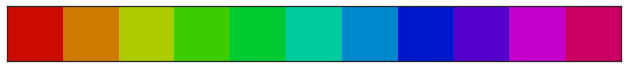

In [7]:
sns.set()
sns.set_style('white')

#plt.rc('font', weight='bold')
current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [8]:
#mixweight
import seaborn as sns
import os



In [9]:
# configuration
from attrdict import AttrDict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


figconfig = AttrDict()
figconfig.wspace=0.025
figconfig.hspace = 0.01
figconfig.width = 8
figconfig.height = 5
figconfig.fontsize = 18
figconfig.fontsiz = 18

In [10]:
nbidx = 2
eps=1e-4

sorted_idx = np.argsort(testset_dict['label'][nbidx])
sorted_label = testset_dict['label'][nbidx][sorted_idx]
imag = testset_dict['imag'][nbidx][sorted_idx]
mainidx = testset_dict['mainidx'][nbidx][sorted_idx]
bgidx = testset_dict['bgidx'][nbidx][sorted_idx]


periodic = 3
#periodic = 6
sorted_label = sorted_label[(periodic-1)::periodic]
imag = imag[(periodic-1)::periodic]
mainidx = mainidx[(periodic-1)::periodic]
bgidx   = bgidx[(periodic-1)::periodic]

In [11]:
def compute_pred(model,model_base,imag,mainidx,bgidx,p=.1):
    density_p = build_density(imag,mainidx,bgidx,share_channel=True,p=p)        
    signal_p = imag*density_p
    model.eval()
    outs = model(density_p.detach().clone().cuda(),signal_p.detach().clone().cuda())            

    model_base.eval()
    outs_base = model_base(density_p.detach().clone().cuda(),signal_p.detach().clone().cuda())            
    
        
    imag_p = (imag*mainidx).cuda()
    imag_p = imag_p.permute(0,2,3,1).contiguous().cuda()
    signal_p = signal_p.permute(0,2,3,1).contiguous().cuda()

    mainidx = mainidx.cuda()                
    #if model.modelname in ['gpdep']:
    outs.pymu = outs.pymu*mainidx[None,...]
    outs.pystd = torch.clamp(outs.pystd*mainidx[None,...],min=eps)    
    outs.pymu = outs.pymu.permute(1,0,3,4,2).contiguous()  #(nb,ns,ngrid1,ngrid2,nchannel)
    outs.pystd = outs.pystd.permute(1,0,3,4,2).contiguous()  #(nb,ns,ngrid1,ngrid2,nchannel)
    #if model_base.modelname in ['base']:    
    outs_base.pymu = outs_base.pymu*mainidx
    outs_base.pystd = torch.clamp(outs_base.pystd*mainidx,min=eps)    
    outs_base.pymu = outs_base.pymu.permute(0,2,3,1).contiguous()
    outs_base.pystd = outs_base.pystd.permute(0,2,3,1).contiguous()

    bgidx = bgidx.permute(0,2,3,1).cuda()    
    
    return imag_p.detach().clone(),signal_p.detach().clone(), bgidx.detach().clone(),outs,outs_base

## conduct prediction

In [12]:
#--------------------------------------------------------------------------------------------------
# set context rate
#--------------------------------------------------------------------------------------------------
month_list = [3,6,9,12]
p1,p2=0.05,0.1

imag_p1,signal_p1, bgidx_p1,outs1,outs_base1 =  compute_pred(model,model_base,imag,mainidx,bgidx,p=p1)
_,signal_p2, bgidx_p2,outs2,outs_base2 =  compute_pred(model,model_base,imag,mainidx,bgidx,p=p2)

#p1,p2=0.05,0.1
imag_p3,signal_p3, bgidx_p3,outs3,outs_base3 =  compute_pred(model,model_base,imag,mainidx,bgidx,p=p1)
_,signal_p4, bgidx_p4,outs4,outs_base4 =  compute_pred(model,model_base,imag,mainidx,bgidx,p=p2)


## image completion

In [13]:
cidx1, j1 =0,0
cidx2, j2 =1,2

## march & sepetember

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yohan/Myenv/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: This figure includes Axes tha

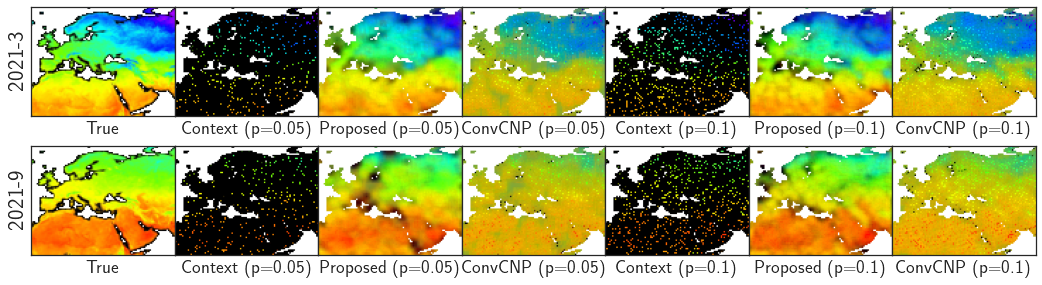

In [14]:
figconfig.num_row = 2
figconfig.num_col = 1+2*3
figconfig.fontsiz = 18.5
#figconfig.fontsiz = 21.5

figconfig.wspace=0.0
if tasktype == 'tempeu':
    figconfig.hspace = -0.53
    fig, axes = plt.subplots(nrows=figconfig.num_row,ncols=figconfig.num_col,figsize=(18,8), tight_layout=True, 
                             gridspec_kw = {'wspace':figconfig.wspace, 'hspace':figconfig.hspace})        

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=figconfig.wspace, hspace=figconfig.hspace)
k1=2
#-------------------------
# 0
#-------------------------
axes[cidx1,0].imshow( (imag_p1[j1]+bgidx_p1[j1]).cpu().data.numpy())
axes[cidx1,0].set_xticks([])
axes[cidx1,0].set_yticks([])


#-------------------------
# 1 to 4
#-------------------------
axes[cidx1,1].imshow( (signal_p1[j1]+bgidx_p1[j1]).cpu().data.numpy())
axes[cidx1,1].set_xticks([])
axes[cidx1,1].set_yticks([])
axes[cidx1,2].imshow( (outs1.pymu[j1][k1]+bgidx_p1[j1]).cpu().data.numpy() )
axes[cidx1,2].set_xticks([])
axes[cidx1,2].set_yticks([])

#axes[cidx,3].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx1,3].imshow( (outs_base1.pymu[j1]+bgidx_p1[j1]).cpu().data.numpy() )
axes[cidx1,3].set_xticks([])
axes[cidx1,3].set_yticks([])

#-------------------------
# 5 to 7
#-------------------------
axes[cidx1,4].imshow( (signal_p2[j1]+bgidx_p2[j1]).cpu().data.numpy())
axes[cidx1,4].set_xticks([])
axes[cidx1,4].set_yticks([])
axes[cidx1,5].imshow( (outs2.pymu[j1][k1]+bgidx_p2[j1]).cpu().data.numpy() )
axes[cidx1,5].set_xticks([])
axes[cidx1,5].set_yticks([])

#axes[cidx,6].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx1,6].imshow( (outs_base2.pymu[j1]+bgidx_p2[j1]).cpu().data.numpy() )
axes[cidx1,6].set_xticks([])
axes[cidx1,6].set_yticks([])


axes[cidx1,0].set_ylabel('2021-{}'.format(month_list[j1]),fontsize=figconfig.fontsiz+4)
axes[cidx1,0].set_xlabel('True',fontsize=figconfig.fontsiz)
axes[cidx1,1].set_xlabel('Context (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,2].set_xlabel('Proposed (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,3].set_xlabel('ConvCNP (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,4].set_xlabel('Context (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx1,5].set_xlabel('Proposed (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx1,6].set_xlabel('ConvCNP (p={})'.format(p2),fontsize=figconfig.fontsiz)



#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------


#-------------------------
# 0
#-------------------------
axes[cidx2,0].imshow( (imag_p3[j2]+bgidx_p3[j2]).cpu().data.numpy())
axes[cidx2,0].set_xticks([])
axes[cidx2,0].set_yticks([])


#-------------------------
# 1 to 4
#-------------------------
axes[cidx2,1].imshow( (signal_p3[j2]+bgidx_p3[j2]).cpu().data.numpy())
axes[cidx2,1].set_xticks([])
axes[cidx2,1].set_yticks([])
axes[cidx2,2].imshow( (outs3.pymu[j2][k1]+bgidx_p3[j2]).cpu().data.numpy() )
axes[cidx2,2].set_xticks([])
axes[cidx2,2].set_yticks([])

#axes[cidx,3].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx2,3].imshow( (outs_base3.pymu[j2]+bgidx_p3[j2]).cpu().data.numpy() )
axes[cidx2,3].set_xticks([])
axes[cidx2,3].set_yticks([])

#-------------------------
# 5 to 7
#-------------------------
axes[cidx2,4].imshow( (signal_p4[j2]+bgidx_p4[j2]).cpu().data.numpy())
axes[cidx2,4].set_xticks([])
axes[cidx2,4].set_yticks([])
k1,k2=1,2
axes[cidx2,5].imshow( (outs4.pymu[j2][k1]+bgidx_p4[j2]).cpu().data.numpy() )
axes[cidx2,5].set_xticks([])
axes[cidx2,5].set_yticks([])

#axes[cidx,6].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx2,6].imshow( (outs_base4.pymu[j2]+bgidx_p4[j2]).cpu().data.numpy() )
axes[cidx2,6].set_xticks([])
axes[cidx2,6].set_yticks([])



#axes[cidx2,0].set_ylabel('2021-{}'.format(12),fontsize=figconfig.fontsiz+4)
axes[cidx2,0].set_ylabel('2021-{}'.format(month_list[j2]),fontsize=figconfig.fontsiz+4)
axes[cidx2,0].set_xlabel('True',fontsize=figconfig.fontsiz)
axes[cidx2,1].set_xlabel('Context (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,2].set_xlabel('Proposed (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,3].set_xlabel('ConvCNP (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,4].set_xlabel('Context (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx2,5].set_xlabel('Proposed (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx2,6].set_xlabel('ConvCNP (p={})'.format(p2),fontsize=figconfig.fontsiz)





filename = tasktype + '_' +model.modelname +'_'+ '_'+'p{}{}'.format(p1,p2) 
#plt.savefig(savefig_dir   + filename + '.' + formatted , format=formatted, dpi=1000, bbox_inches='tight')
plt.show()

#print(savefig_dir   + filename   + '_saved')
print('\n')




## june & december

In [15]:
j1,j2 = 1,3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yohan/Myenv/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: This figure includes Axes tha

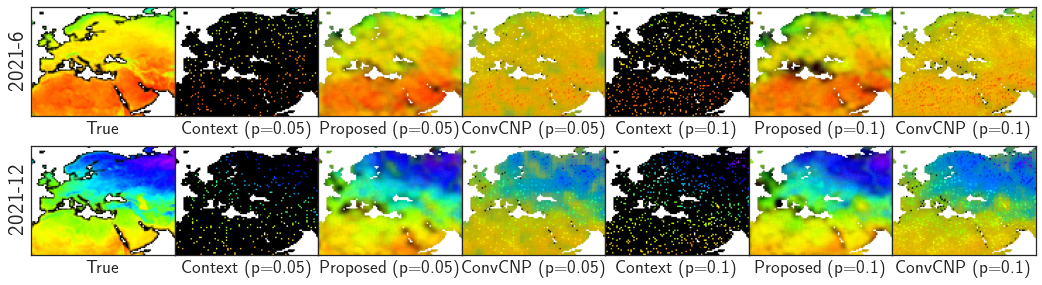

In [16]:
figconfig.num_row = 2
figconfig.num_col = 1+2*3
figconfig.fontsiz = 18.5
#figconfig.fontsiz = 21.5

figconfig.wspace=0.0
if tasktype == 'tempeu':
    figconfig.hspace = -0.53
    fig, axes = plt.subplots(nrows=figconfig.num_row,ncols=figconfig.num_col,figsize=(18,8), tight_layout=True, 
                             gridspec_kw = {'wspace':figconfig.wspace, 'hspace':figconfig.hspace})        

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=figconfig.wspace, hspace=figconfig.hspace)
k1=2
#-------------------------
# 0
#-------------------------
axes[cidx1,0].imshow( (imag_p1[j1]+bgidx_p1[j1]).cpu().data.numpy())
axes[cidx1,0].set_xticks([])
axes[cidx1,0].set_yticks([])


#-------------------------
# 1 to 4
#-------------------------
axes[cidx1,1].imshow( (signal_p1[j1]+bgidx_p1[j1]).cpu().data.numpy())
axes[cidx1,1].set_xticks([])
axes[cidx1,1].set_yticks([])
axes[cidx1,2].imshow( (outs1.pymu[j1][k1]+bgidx_p1[j1]).cpu().data.numpy() )
axes[cidx1,2].set_xticks([])
axes[cidx1,2].set_yticks([])

#axes[cidx,3].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx1,3].imshow( (outs_base1.pymu[j1]+bgidx_p1[j1]).cpu().data.numpy() )
axes[cidx1,3].set_xticks([])
axes[cidx1,3].set_yticks([])

#-------------------------
# 5 to 7
#-------------------------
axes[cidx1,4].imshow( (signal_p2[j1]+bgidx_p2[j1]).cpu().data.numpy())
axes[cidx1,4].set_xticks([])
axes[cidx1,4].set_yticks([])
axes[cidx1,5].imshow( (outs2.pymu[j1][k1]+bgidx_p2[j1]).cpu().data.numpy() )
axes[cidx1,5].set_xticks([])
axes[cidx1,5].set_yticks([])

#axes[cidx,6].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx1,6].imshow( (outs_base2.pymu[j1]+bgidx_p2[j1]).cpu().data.numpy() )
axes[cidx1,6].set_xticks([])
axes[cidx1,6].set_yticks([])


axes[cidx1,0].set_ylabel('2021-{}'.format(month_list[j1]),fontsize=figconfig.fontsiz+4)
axes[cidx1,0].set_xlabel('True',fontsize=figconfig.fontsiz)
axes[cidx1,1].set_xlabel('Context (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,2].set_xlabel('Proposed (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,3].set_xlabel('ConvCNP (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx1,4].set_xlabel('Context (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx1,5].set_xlabel('Proposed (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx1,6].set_xlabel('ConvCNP (p={})'.format(p2),fontsize=figconfig.fontsiz)



#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------


#-------------------------
# 0
#-------------------------
axes[cidx2,0].imshow( (imag_p3[j2]+bgidx_p3[j2]).cpu().data.numpy())
axes[cidx2,0].set_xticks([])
axes[cidx2,0].set_yticks([])


#-------------------------
# 1 to 4
#-------------------------
axes[cidx2,1].imshow( (signal_p3[j2]+bgidx_p3[j2]).cpu().data.numpy())
axes[cidx2,1].set_xticks([])
axes[cidx2,1].set_yticks([])
axes[cidx2,2].imshow( (outs3.pymu[j2][k1]+bgidx_p3[j2]).cpu().data.numpy() )
axes[cidx2,2].set_xticks([])
axes[cidx2,2].set_yticks([])

#axes[cidx,3].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx2,3].imshow( (outs_base3.pymu[j2]+bgidx_p3[j2]).cpu().data.numpy() )
axes[cidx2,3].set_xticks([])
axes[cidx2,3].set_yticks([])

#-------------------------
# 5 to 7
#-------------------------
axes[cidx2,4].imshow( (signal_p4[j2]+bgidx_p4[j2]).cpu().data.numpy())
axes[cidx2,4].set_xticks([])
axes[cidx2,4].set_yticks([])
k1,k2=1,2
axes[cidx2,5].imshow( (outs4.pymu[j2][k1]+bgidx_p4[j2]).cpu().data.numpy() )
axes[cidx2,5].set_xticks([])
axes[cidx2,5].set_yticks([])

#axes[cidx,6].imshow( (outs.pymu[j][k2]+bgidx_p[j]).cpu().data.numpy() )
axes[cidx2,6].imshow( (outs_base4.pymu[j2]+bgidx_p4[j2]).cpu().data.numpy() )
axes[cidx2,6].set_xticks([])
axes[cidx2,6].set_yticks([])



#axes[cidx2,0].set_ylabel('2021-{}'.format(12),fontsize=figconfig.fontsiz+4)
axes[cidx2,0].set_ylabel('2021-{}'.format(month_list[j2]),fontsize=figconfig.fontsiz+4)
axes[cidx2,0].set_xlabel('True',fontsize=figconfig.fontsiz)
axes[cidx2,1].set_xlabel('Context (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,2].set_xlabel('Proposed (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,3].set_xlabel('ConvCNP (p={})'.format(p1),fontsize=figconfig.fontsiz)
axes[cidx2,4].set_xlabel('Context (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx2,5].set_xlabel('Proposed (p={})'.format(p2),fontsize=figconfig.fontsiz)
axes[cidx2,6].set_xlabel('ConvCNP (p={})'.format(p2),fontsize=figconfig.fontsiz)





filename = tasktype + '_' +model.modelname +'_'+ '_'+'p{}{}'.format(p1,p2) 
#plt.savefig(savefig_dir   + filename + '.' + formatted , format=formatted, dpi=1000, bbox_inches='tight')
plt.show()

#print(savefig_dir   + filename   + '_saved')
print('\n')


